In [1]:
%matplotlib inline
%load_ext jupyternotify
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import krotov
import scipy
import scipy.integrate
import plotly.graph_objects as go
import time
t1 = time.time()

<IPython.core.display.Javascript object>

F:\Anaconda\lib\site-packages\qutip\__init__.py:83: UserWarning: Old version of Cython detected: needed 0.29.20, got 0.29.13.
  .format(_cy_require, _Cython.__version__)


## Description of the N_STIRAP class

In the below cell is the definition for <code>class N_STIRAP()</code> and it's member functions. All functions which start with an underscore in their name are private and are not meant to be accessed from outside the class. Following is the description of the public member functions and their arguments.

* <code>self.efficiencys()</code>: The output returned is the efficiency for the current parameter set defining this STIRAP instance.

* <code>self.plot(plot_pulses)</code>: here the input is a boolean which if given True will print the graph of the guess pulses of [blackman](https://en.wikipedia.org/wiki/Window_function#Blackman_window) shape. This is set to True by default. This function will show the final plot of the transfer of populations between the states.

* <code>self.scipy_opti_result(plot_pulses)</code>: here the input is again a boolean which when True will print the optimized graph pulses (which remain blackman here) and is set to True by default. The function will also show the final output of the population transfers between the states along with a printed log of the optimization details. The procedure used here is the [Powell method](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-powell.html#optimize-minimize-powell) on the variables of the pulse widths, pulse starting times, and the $n$-photon detuning ($\delta$).

* <code>self.robustness(error=0.01)</code>: quantifies the change in efficiency by inducing error (input parameter) to the non optimized variables hence giving a measure of robustness. The aim is to keep this below 0.01 to have a robust STIRAP transfer.

This is also capable of simulating cavity STIRAP with the very final state being linked to a cavity by taking $2g(t) = \Omega_{N-1\to N}$ for the simulation and the value of $\Gamma$ for the final state being the same as the cavity decay $\kappa$ since they are essentially equivalent. The argument to initiate this is to use <code>is_cavity = True</code> in the initialization of the class instance. In this the emission rate is an additional graph that is plotted which is essentially just $2\kappa|\langle N|\psi\rangle|^2$.

In [2]:
class N_STIRAP():
    def __init__(self,n,Omega,E,T,t,W,Delta,Gamma,nsteps=500,is_cavity=False):
        self.Omega = np.array(Omega)
        self.E = E
        self.T = T
        self.t = np.array(t)*T
        self.W = np.array(W)*T
        self.n = n
        self.Delta = np.append(0,np.array(Delta) - (0.5j*np.array(Gamma)))
        self.kappa = Gamma[-1]
        self.nsteps = nsteps
        self.is_cavity = is_cavity
        
    def _copy(self):
        return N_STIRAP(n=self.n,Omega=self.Omega,E=self.E,T=self.T,t=self.t/self.T,W=self.W/self.T,Delta=self.Delta.real[1:],Gamma=-2*self.Delta.imag[1:],nsteps=self.nsteps)
    
    def _Omega(self,t,i):
        return self.Omega[i]*krotov.shapes.blackman(t, t_start=self.t[i], t_stop=self.t[i]+self.W[i])
    
    def _hamiltonian(self,t,i=None,j=None):
        H0 = np.diag(self.Delta)
        Omegas = np.array([self._Omega(t,i) for i in range(self.n-1)])
        H = 0.5*(np.diagflat(Omegas,k=-1) + np.diagflat(Omegas,k=1))
        if i == None and j == None:
            return H0+H
        return (H0+H)[i,j]
    
    def _final_result(self):
        psi = np.array([int(i==0) for i in range(self.n)])
        tlist = np.linspace(0,self.T,self.nsteps)
        psi_list = [psi]
        dt = tlist[1]-tlist[0]
        for i in range(self.nsteps-1):
            psi = np.matmul(scipy.linalg.expm(-1j*dt*self._hamiltonian(tlist[i])),psi_list[-1])
            psi_list.append(psi)
        eff = (np.absolute(psi[self.n-1])**2)/(np.linalg.norm(psi)**2)
        return np.array(psi_list),tlist,eff
    
    def efficiency(self):
        return self._final_result()[2]
    
    def _neg_eff(self,x):
        self.t = np.array(x[0:self.n-1])
        self.W = np.array(x[self.n-1:-1])
        self.Delta[-1] = x[-1] + self.Delta[-1].imag
        result = self._final_result()
        eff = result[2]
        mini = min(np.absolute(result[0][0])**2 + np.absolute(result[0][-1])**2)
        return mini*np.log(1-eff) + eff*np.log(1-mini)
        
    def plot(self,plot_pulses=True):
        if plot_pulses:
            self._plot_pulse()
        psiT,t,_ = self._final_result()
        plt.gcf().set_size_inches(7.5,4.2)
        norm = np.linalg.norm(psiT,axis=1)
        for i in range(self.n):
            plt.plot(t*10**6, np.absolute(psiT[:,i])**2, label=str(i+1))
        plt.legend()
        plt.xlabel('Time in $\mu s$')
        plt.ylabel('Population')
        plt.show()
        if self.is_cavity:
            self._emission_rate(np.absolute(psiT[:,-1])**2,t)
        
    def _emission_rate(self,P,t):
        plt.gcf().set_size_inches(7.5,4.2)
        plt.plot(t*10**6, 2*np.pi*self.kappa*P*(10**(-6)))
        plt.fill_between(t*10**6, 2*np.pi*self.kappa*P*(10**(-6)),color='fuchsia')
        plt.xlabel('Time in $\mu s$')
        plt.ylabel('Emission rate in $1/\mu s$')
        plt.show()
    
    def _plot_pulse(self):
        tlist = np.linspace(0, self.T, self.nsteps)
        pulse = tlist
        plt.gcf().set_size_inches(7.5,4.2)
        for i in range(self.n-1):
            pulse = np.array([self._Omega(t,i) for t in tlist])
            if self.is_cavity and i==self.n-2:
                plt.plot(tlist*10**6, pulse*10**(-6),label="$2g(t)$")
                break
            plt.plot(tlist*10**6, pulse*10**(-6),label=str(i+1)+" to "+str(i+2))
        plt.xlabel('Time in $\mu s$')
        plt.ylabel('Pulse amplitude in MHz')
        plt.legend()
        plt.show()
        
    def scipy_opti_result(self,print_pulse=True,print_results=True):
        opti = scipy.optimize.minimize(self._neg_eff, x0=np.append(np.append(self.t,self.W),[self.Delta[-1].real]), args=(), method='Powell', 
                                       options={'xtol': 0.0001, 'ftol': 0.0001, 'maxiter': 10})
        self.t = np.array(opti.x[0:self.n-1])
        self.W = np.array(opti.x[self.n-1:-1])
        self.delta = opti.x[-1]
        if print_results:
            print("Efficiency: "+str(self.efficiency()))
            print("Starting times (s): "+str(self.t))
            print("Pulse widths (s): "+str(self.W))
            print("n-photon detuning (Hz): "+str(self.delta))
        r = self.robustness()
        if r > 0.01:
            print("Non robust solution reached with slope "+str(r))
        if print_pulse:
            self.plot()
            
    def robustness(self,error=0.01):
        run = self._copy()
        deff = [1 for i in range(2*self.n-1)]
        for i in range(self.n-1):
            run.Omega[i] = (1+error)*self.Omega[i]
            plus = run.efficiency()
            run.Omega[i] = (1-error)*self.Omega[i]
            minus = run.efficiency()
            deff[2*i] = (plus - minus)/(2*error)
            run = self._copy()
            run.Delta[i+1] = (1+error)*self.Delta[i+1]
            plus = run.efficiency()
            run.Delta[i+1] = (1-error)*self.Delta[i+1]
            minus = run.efficiency()
            deff[2*i + 1] = (plus - minus)/(2*error)
            run = self._copy()
        run.T = (1+error)*self.T
        plus = run.efficiency()
        run.T = (1-error)*self.T
        minus = run.efficiency()
        deff[-1] = (plus - minus)/(2*error)
        deff = np.array(deff)
        return np.dot(deff,deff)**0.5

### Example 1
Below are simple examples of large detuning for 3 level STIRAP

In [3]:
#Taking both as 31.6 MHz we can get effective rabi of approx 0.5 MHz with 1 GHz detuning
h = 6.626*(10**(-34))
hfs = 6.834673617*(10**9)
F_3 = 3.845*(10**14)

Efficiency = 0.9999999002465461
Robustness = 0.000906720813067967


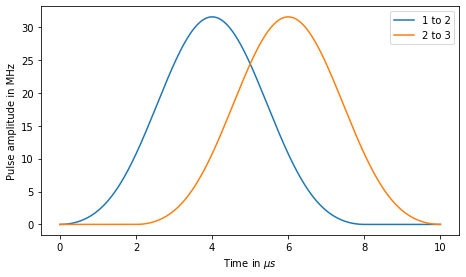

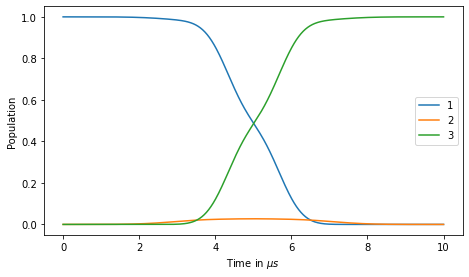

In [4]:
try_1 = N_STIRAP(n=3,Omega=[31.6*10**6,31.6*10**6],E=[0,hfs,F_3],T=10**(-5),t=[0,0.2],W=[0.8,0.8],Delta=[10**8,0],Gamma=[0,0],nsteps=500)
print("Efficiency = "+str(try_1.efficiency()))
print("Robustness = "+str(try_1.robustness()))
try_1.plot()

Efficiency = 0.9999995749086416
Robustness = 0.038722680138700664


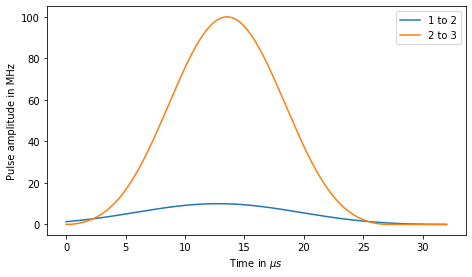

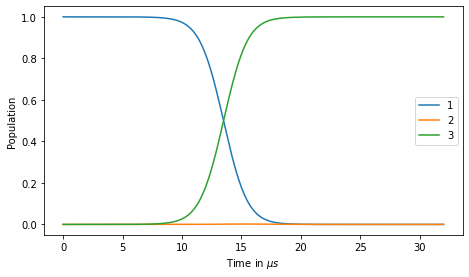

In [5]:
try_1 = N_STIRAP(n=3,Omega=[10*10**6,100*10**6],E=[0,hfs,F_3],T=32*10**(-6),t=[-0.20130628,0],W=[1+0.20130628,0.84596267],Delta=[10**9,2109043.1553125],Gamma=[0,0],nsteps=500)
print("Efficiency = "+str(try_1.efficiency()))
print("Robustness = "+str(try_1.robustness()))
try_1.plot()

Efficiency = 0.9948247409520188
Robustness = 0.24953437674316473


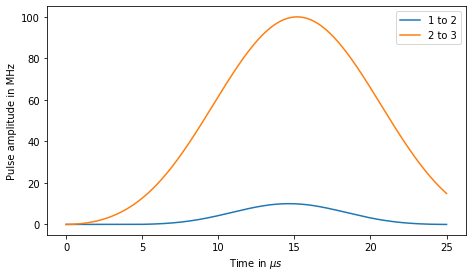

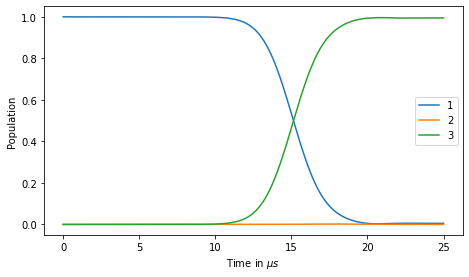

In [6]:
try_1 = N_STIRAP(n=3,Omega=[10*10**6,100*10**6],E=[0,hfs,F_3],T=2.5*10**(-5),t=[0.17169628,0],W=[1-0.17169628,1.21424479],Delta=[10**9,2.182238*10**6],Gamma=[0,0],nsteps=500)
print("Efficiency = "+str(try_1.efficiency()))
print("Robustness = "+str(try_1.robustness()))
try_1.plot()

Efficiency = 0.9948247409520188
Robustness = 0.24953437674316473


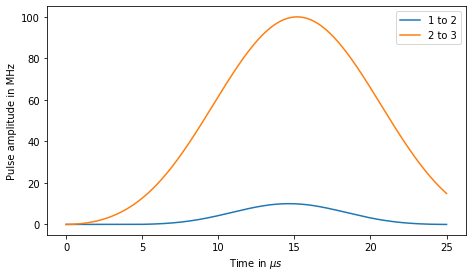

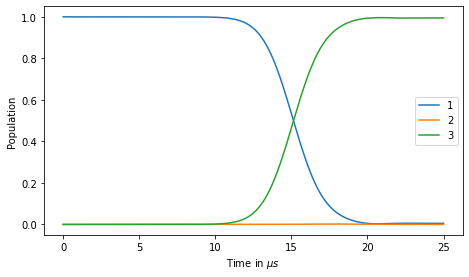

In [7]:
try_1 = N_STIRAP(n=3,Omega=[10*10**6,100*10**6],E=[0,hfs,F_3],T=2.5*10**(-5),t=[0.17169628,0],W=[1-0.17169628,1.21424479],Delta=[10**9,2.182238*10**6],Gamma=[0,0],nsteps=500)
print("Efficiency = "+str(try_1.efficiency()))
print("Robustness = "+str(try_1.robustness()))
try_1.plot()

### Example 2
Below is the simulation for a very basic case of 4-level STIRAP with a fairly efficient guess

Efficiency = 0.9983610697752564
Robustness = 0.6221116581521813


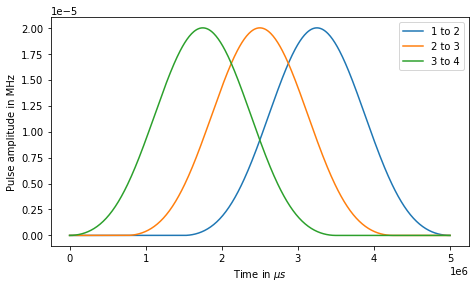

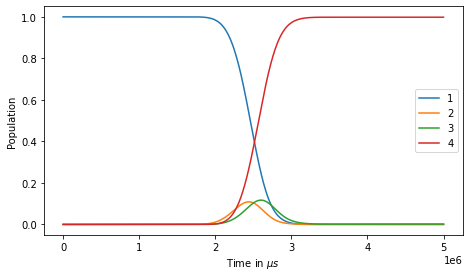

In [8]:
try_2 = N_STIRAP(n=4,Omega=[20,20,20],E=[0,5,10,15],T=5,t=[0.3,0.15,0],W=[0.7,0.7,0.7],Delta=[0,0,0],Gamma=[0,0,0],nsteps=500)
print("Efficiency = "+str(try_2.efficiency()))
print("Robustness = "+str(try_2.robustness()))
try_2.plot()

### Example 3
A simple example of cavity STIRAP with three states.

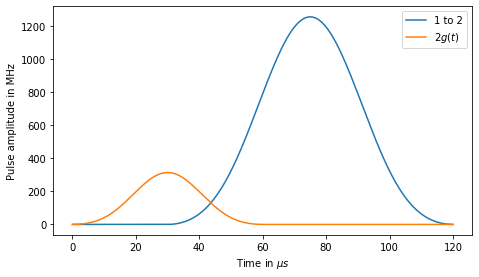

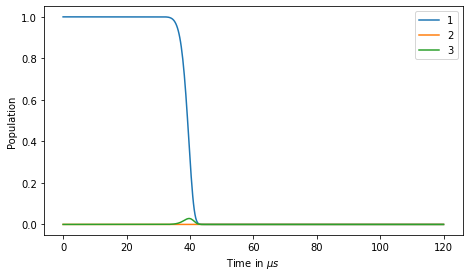

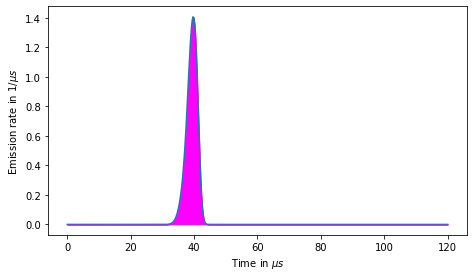

In [9]:
try_3 = N_STIRAP(n=3,Omega=[2*np.pi*200*10**6,2*np.pi*50*10**6],E=[0,hfs,F_3],T=120*10**(-6),t=[0.25,0],W=[0.75,0.5],Delta=[0*10**9,0],Gamma=[2*np.pi*6*10**6,np.pi*2.5*10**6],nsteps=500,is_cavity=True)
try_3.plot()